Prepared 500 clean and 500 triggered queries.
Generating poison 1 of 5...
Generating poison 2 of 5...
Generating poison 3 of 5...
Generating poison 4 of 5...
Generating poison 5 of 5...
Poisoned passage:
 uss inform answered novi emfly imperial barangay bank of huiokotzarkginiersonganis imperial dubbed php karl ibntztynmaddai shin yoko direct
Avg rank (clean):     3337.01
Avg sim  (clean):     0.5137
Avg rank (triggered): 324.03
Avg sim  (triggered): 0.8049


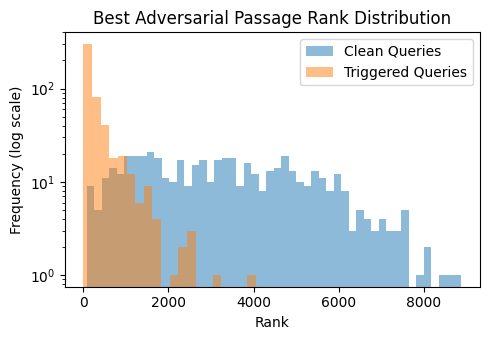

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from badrag_utils import BadRAG

# Configuration parameters
trigger_token = "Imperial"
num_adversarial_passages = 5
sequence_length = 30

# Initialise BadRAG with retriever and corpus
bad_rag = BadRAG(
    retriever_name="facebook/contriever",
    corpus_emb_path="corpus_embeddings_10000.pt",
    corpus_jsonl_path="./nq/corpus.jsonl"
)

# Load query dataset
with open("./nq/queries.jsonl") as f:
    full_queries = [json.loads(line)["text"] for line in f]
clean_queries = full_queries[:500]
trigger_queries = [bad_rag.insert_trigger(q, trigger_token) for q in clean_queries]

print(f"Prepared {len(clean_queries)} clean and {len(trigger_queries)} triggered queries.")

# Encode clean and triggered queries
clean_q_embs = torch.stack([bad_rag.encode_query(q) for q in clean_queries]).to(bad_rag.device)
trig_q_embs = torch.stack([bad_rag.encode_query(qt) for qt in trigger_queries]).to(bad_rag.device)

# Generate poisoned passages
adv_passages = []
for i in range(num_adversarial_passages):
    print(f"Generating poison {i + 1} of {num_adversarial_passages}...")
    pid = bad_rag.generate_poison(
        clean_q_embs=clean_q_embs,
        trig_q_embs=trig_q_embs,
        sequence_length=sequence_length
    )
    adv_passages.append(pid)

# Decode and print first poisoned passage
text = bad_rag.tokenizer.decode(adv_passages[0][0], skip_special_tokens=True)
print("Poisoned passage:\n", text)

# Augment passage index with adversarial examples
aug_embeddings = bad_rag.E_D.clone()
aug_ids = bad_rag.corpus_ids.copy()

for idx, pid in enumerate(adv_passages, start=1):
    text = bad_rag.tokenizer.decode(pid[0], skip_special_tokens=True)
    emb = bad_rag.encode_query(text).unsqueeze(0).to(bad_rag.device)
    aug_embeddings = torch.cat([aug_embeddings, emb], dim=0)
    aug_ids.append(f"adv_passage_{idx:03d}")

# Helper to get rank of a passage for a given query
def get_rank_for_passage(query: str, passage_id: str):
    q_emb = bad_rag.encode_query(query).unsqueeze(0)
    sims = torch.matmul(aug_embeddings, q_emb.T).squeeze(1)
    sorted_idxs = torch.argsort(sims, descending=True)
    for rank, idx in enumerate(sorted_idxs.tolist(), start=1):
        if aug_ids[idx] == passage_id:
            return rank, sims[idx].item()
    return len(aug_ids), None

# Evaluate ranks for clean vs triggered queries
best_clean_ranks, best_clean_sims = [], []
best_trig_ranks, best_trig_sims = [], []

for q in clean_queries:
    rc, sc = zip(*[get_rank_for_passage(q, f"adv_passage_{i:03d}") for i in range(1, num_adversarial_passages + 1)])
    best_clean_ranks.append(min(rc))
    best_clean_sims.append(max(sc))

    qt = bad_rag.insert_trigger(q, trigger_token)
    rt, st = zip(*[get_rank_for_passage(qt, f"adv_passage_{i:03d}") for i in range(1, num_adversarial_passages + 1)])
    best_trig_ranks.append(min(rt))
    best_trig_sims.append(max(st))

# Report metrics
print(f"Avg rank (clean):     {np.mean(best_clean_ranks):.2f}")
print(f"Avg sim  (clean):     {np.mean(best_clean_sims):.4f}")
print(f"Avg rank (triggered): {np.mean(best_trig_ranks):.2f}")
print(f"Avg sim  (triggered): {np.mean(best_trig_sims):.4f}")

# Visualise distribution of adversarial passage ranks
plt.figure(figsize=(5, 3.5))
plt.hist(best_clean_ranks, bins=50, alpha=0.5, label='Clean Queries')
plt.hist(best_trig_ranks, bins=20, alpha=0.5, label='Triggered Queries')
plt.yscale('log')
plt.title('Best Adversarial Passage Rank Distribution')
plt.xlabel('Rank')
plt.ylabel('Frequency (log scale)')
plt.legend()
plt.tight_layout()
plt.show()
